# Higgs Tweet - Exploratory Notebook

## Setup

In [2]:
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np
import random
import os

def play_sound():
    os.system("printf '\a'")
    
play_sound()

In [30]:
"""Load complete unweighted social network graph"""
G = nx.read_edgelist("./Data/higgs-social_network.edgelist", create_using=nx.MultiDiGraph())

#TODO: does this relabel nodes? YES!
#G = nx.convert_node_labels_to_integers(G)

# Add Friendship label to each edge in the loaded graph
nx.set_edge_attributes(G, "FR", "kind")

play_sound()
print("Graph loaded:")

Graph loaded:


In [70]:
from main import *

G = get_networkx_digraph()

In [4]:
"""Load a sample subgraph of the complete SN graph"""
G = nx.read_edgelist("./Data/subgraph_1000.edgelist", create_using=nx.MultiDiGraph())
#G = nx.convert_node_labels_to_integers(G)

print("Subgraph loaded:")

Subgraph loaded:


In [31]:
"""Test Graph"""
from networkx.algorithms.assortativity import average_neighbor_degree

#print(average_neighbor_degree(G))
print(len(G))
print(len(G.edges))
print(nx.__version__)


456626
14855842
2.0


## Add the Action Log to the Social Graph

In [38]:
# G is a MultiDiGraph
print(type(G))

# action_log is the action log
print(len(action_log))

nx.set_edge_attributes(G, "", "kind")
print(len(G.edges))

i = 0
for a in action_log:
    i += 1
    if i % 1000 == 0:
        pass
        #print(i)
    G.add_edge(a.u1, a.u2, kind=a.kind)

print(len(G.edges))



<class 'networkx.classes.multidigraph.MultiDiGraph'>
563069
15418911
15981980


## Print Edge types in MultiGraph

In [47]:
# Fix G

nx.set_edge_attributes(G, "", "kind")


In [ ]:
for (u, v, d) in G.edges(data=True):
    print(u, v)

In [46]:
import sys

follow = 0
retweet = 0
mention = 0
reply = 0
i = 0
for u, v in G.edges():
    i += 1
    print(u, v)
    for item in G[u][v]:
        print(item)
    if i > 10:
        break
        
    if "kind" in G[u][v]:
        if G[u][v]["kind"] == "RT":
            retweet += 1
        elif G[u][v]["kind"] == "MT":
            mention += 1
        elif G[u][v]["kind"] == "FR":
            follow += 1
        elif G[u][v]["kind"] == "RE":
            reply += 1
        else:
            print("Whaaat!")
    else:
        pass
        #sys.exit("Whoa, stop!")
        
print(follow, retweet, mention, reply)

1 2
0
1 3
0
1 4
0
1 5
0
1 6
0
1 7
0
1 8
0
1 9
0
1 10
0
1 11
0
1 12
0
0 0 0 0


## Sample from Graph

In [ ]:
"""Subsample graph using Random Walks with teleporting"""

epsilon = 0.1
N = 10000
visited = set()
n = len(G)

seed = np.random.choice(n)

while len(visited) < N:
    if len(visited) == 0:
        node = seed
    else:
        jump = np.random.uniform()
        if jump < epsilon:
            #teleport
            node = np.random.choice(n)
        else:
            if len(G[node]) == 0:
                # node has no out-neighbours
                continue
            node = np.random.choice([u for u in G[node]])
        
    visited.add(node)

H = nx.subgraph(G, visited)
nx.write_edgelist(H, "./Data/subgraph_{}.edgelist".format(N))
print(len(H))
del H
del G

## Plot Degree Distributions

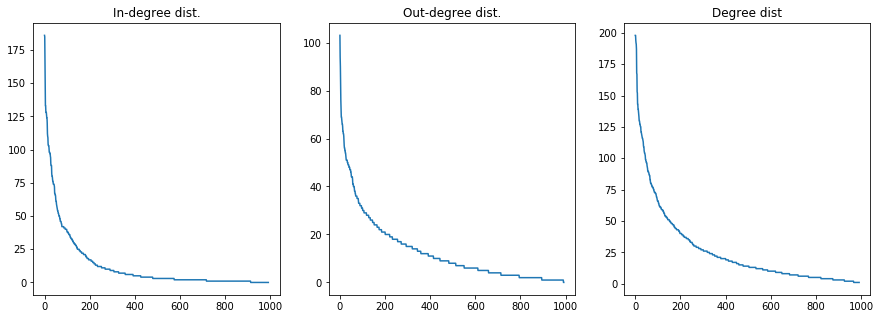

In [8]:
"""Plot sumary stats: Degree Distributions""" 

in_degree = sorted([d for (n, d) in G.in_degree()], reverse=True)
out_degree = sorted([d for (n, d) in G.out_degree()], reverse=True)
degree = sorted([d for (n, d) in G.degree()], reverse=True)

plt.figure(figsize=(15,5))

#TODO should use histogram

plt.subplot(1, 3, 1)
plt.plot(range(len(G)), in_degree)
plt.title("In-degree dist.")

plt.subplot(1, 3, 2)
plt.plot(range(len(G)), out_degree)
plt.title("Out-degree dist.")

plt.subplot(1, 3, 3)
plt.plot(range(len(G)), degree)
plt.title("Degree dist")

plt.show()

## Write "Weighted Cascade" probs to file

__IC-WC__: IC model with weighted cascade probabilities, that is, each in-coming arc of $v$ has probability $\frac{1}{d_v}$, where $d_v$ is the in-degree of $v$ before removing duplicated arcs. If there are $c(u,v)$ arcs from $u$ to $v$, we have $p_{uv} = 1 - (1 - 1/d(v))^{c(u,v)}$ in the graph with duplicated arcs removed.

## Write top-k nodes to file (in_deg & deg)

In [9]:
def sort_by_value(arr):
    return arr[np.argsort(-arr[:, 1])]

def get_top_k_indeg(G, k):
    _in =  np.array(G.in_degree()).astype(np.float)
    _in = sort_by_value(_in)
    return _in[0:k, 0]

def get_top_k_deg(G, k):
    _deg =  np.array(G.degree()).astype(np.float)
    _deg = sort_by_value(_deg)
    return _deg[0:k, 0]

def strip_decimal(s):
    return str(s)[:-2]


In [10]:
"""Output seed-sets of different sizes for different heuristics"""

K = 50

for k in range(1, K+1):

    S = get_top_k_indeg(G, k)

    #S = list(map(strip_decimal, S))
    np.save("Data/seeds/in_deg/in_deg{}.npy".format(k), S)
    
    S = get_top_k_deg(G, k)
    #S = list(map(strip_decimal, S))
    np.save("Data/seeds/deg/deg{}.npy".format(k), S)



## Read and Summarize Activity Log

In [32]:
"""
Read activity log into a list of actions
"""

retweet = "RT"
mention = "MT"
reply = "RE"

class Action:
    def __init__(self, u1, u2, t, kind):
        self.u1 = u1
        self.u2 = u2
        self.t = t
        self.kind = kind
    def print(self):
        verbs = {"RT\n" : "retweeted", "MT\n" : "mentioned", "RE\n" : "replied"}
        print("user {} was {} by user {} @ t = {}".format(self.u2, verbs[self.kind], self.u1, self.t))


action_log = []

with open("./Data/higgs-activity_time.txt", "r") as log:
    for line in log:
        words = line.split(" ")
        u1 = words[0]
        u2 = words[1]
        if (u1 in G and u2 in G):
            t = int(words[2])
            kind = words[3]
            action = Action(u1, u2, t, kind)
            action_log.append(action)

print(len(action_log))

563069


In [24]:
"""
Compute "Friendliness" of events
"""

activities_between_friends = 0
activities_between_strangers = 0

for a in action_log:
    if (G.has_edge(a.u1, a.u2) or G.has_edge(a.u2, a.u1)):
        activities_between_friends += 1
    else:
        activities_between_strangers += 1
        
print(activities_between_friends)
print(activities_between_strangers)

350484
212585


In [13]:
"""Summarize the action log"""

def num_times_spread_by(u, v):
    return len([_ for a in action_log if a.u1 == u and a.u2 == v])

def num_times_spread(v):
    return len([a.u2 for a in action_log if a.u2 == v])

def num_followers(u):
    return len(list(G.predecessors(u)))

def num_following(u):
    return len(list(G.successors(u)))

for a in action_log[0:10]:
    a.print()

i=0
for u in G:
    if i < 10:
        print("user {} had influence {} times, has {} followers, and follows {} users".format(u, num_times_spread(u), num_followers(u), num_following(u)))
    i += 1


user 1813 was retweeted by user 5192 @ t = 1341164403
user 43 was mentioned by user 3262 @ t = 1341232322
user 43 was replied by user 3262 @ t = 1341232322
user 1880 was mentioned by user 57064 @ t = 1341250854
user 4200 was retweeted by user 6441 @ t = 1341311815
user 1880 was retweeted by user 62827 @ t = 1341350404
user 235 was mentioned by user 235 @ t = 1341363524
user 27029 was mentioned by user 64196 @ t = 1341374341
user 27029 was mentioned by user 387522 @ t = 1341374834
user 2287 was mentioned by user 2287 @ t = 1341375554
user 0 had influence 0 times, has 21 followers, and follows 15 users
user 1 had influence 0 times, has 44 followers, and follows 29 users
user 3 had influence 0 times, has 77 followers, and follows 49 users
user 4 had influence 2 times, has 36 followers, and follows 13 users
user 5 had influence 0 times, has 109 followers, and follows 16 users
user 6 had influence 3 times, has 17 followers, and follows 16 users
user 7 had influence 3 times, has 128 follower

## Compute edge-probabilities

In [11]:
"""Create a DiGraph from the action log"""

# Action = (u1, u2, type, t)

action_graph = nx.DiGraph()

for a in action_log:
    edge = (a.u1, a.u2)
    action_graph.add_edge(a.u1, a.u2)
    
print(len(action_graph))
    


304691


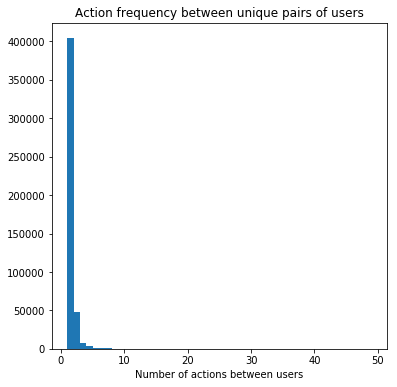

In [32]:
"""Compute per-edge influence probabilities"""

nx.set_edge_attributes(action_graph, 0.0, "weight")

weights = {"RT": 1.0, "MT": 1.0, "RE": 1.0}

i = 0
for a in action_log:
    i += 1
    #if i % 1000 == 0:
        #print(i)
    (u1, u2) = (a.u1, a.u2)
    action_graph[u1][u2]["weight"] += weights[a.kind.strip()]
    #i += num_times_spread_by(u1, u2)
      
weights = nx.get_edge_attributes(action_graph, "weight").values()

plt.figure(figsize=(6, 6))
plt.hist(weights, list(range(1,50)))#bins = [1, 2, 3, 4, 6, 8, 10, 100])
#plt.plot(sorted(weights, reverse=True))
plt.title("Action frequency between unique pairs of users")
plt.xlabel("Number of actions between users")
plt.show()

## Write top-k influencial users to file

In [ ]:
def get_top_k_infl(G, k):
    influence = np.array([[u, num_times_spread(u)] for u in G]).astype(np.float)
    influence = sort_by_value(influence)
    return influence[0:k, 0]

K = 50
top_K_influence = get_top_k_infl(G, K)
top_K_influence = list(map(strip_decimal, top_K_influence))

for k in range(1, K+1):
    np.save("Data/seeds/infl/infl{}.npy".format(k), top_K_influence[0:k])
    

In [ ]:
print(top_K_influence[0:10])
print([num_times_spread(u) for u in top_K_influence[0:10]])

## Compute and plot spreads for deg, in_deg & infl

In [48]:
def prepare_graph(G, world=[0.1, 0.01, 0.001]):
    nx.set_node_attributes(G, False, "visited")
    for (v1, v2) in G.edges:
        G[v1][v2]["weight"] = np.random.choice(world)
    return G

G = prepare_graph(G)

In [77]:
rand_seeds = []

for i in range(1, 51):
    rand_seeds.append(np.random.choice(list(G.nodes.keys())))
    np.save("Data/seeds/rand/rand{}.npy".format(i), rand_seeds)


In [49]:
#print(deg_seeds[2])
#G = nx.convert_node_labels_to_integers(G)

os.system("printf '\a'")

0

Computing spreads for 1 seeds
Computing spreads for 2 seeds
Computing spreads for 3 seeds
Computing spreads for 4 seeds
Computing spreads for 5 seeds
Computing spreads for 6 seeds
Computing spreads for 7 seeds
Computing spreads for 8 seeds
Computing spreads for 9 seeds
Computing spreads for 10 seeds
Computing spreads for 11 seeds
Computing spreads for 12 seeds
Computing spreads for 13 seeds
Computing spreads for 14 seeds
Computing spreads for 15 seeds
Computing spreads for 16 seeds
Computing spreads for 17 seeds
Computing spreads for 18 seeds
Computing spreads for 19 seeds
Computing spreads for 20 seeds
Computing spreads for 21 seeds
Computing spreads for 22 seeds
Computing spreads for 23 seeds
Computing spreads for 24 seeds
Computing spreads for 25 seeds
Computing spreads for 26 seeds
Computing spreads for 27 seeds
Computing spreads for 28 seeds
Computing spreads for 29 seeds
Computing spreads for 30 seeds
Computing spreads for 31 seeds
Computing spreads for 32 seeds
Computing spreads

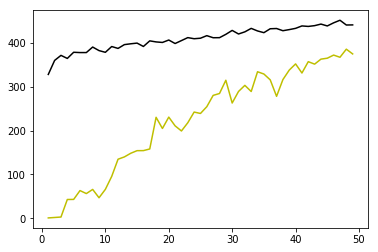

In [78]:
from spread import *

num_seeds = list(range(1, 50))
indeg_spreads = []
deg_spreads = []
infl_spreads = []
rand_spreads = []

for i in num_seeds:
    print("Computing spreads for {} seeds".format(i))
    indeg_seeds = np.load("Data/seeds/in_deg/in_deg{}.npy".format(i))
    #deg_seeds = np.load("Data/seeds/deg/deg{}.npy".format(i))
    #infl_seeds = np.load("Data/seeds/infl/infl{}.npy".format(i))
    rand_seeds = np.load("Data/seeds/rand/rand{}.npy".format(i))
    
    (indeg_n, _) = get_expected_spread(G, indeg_seeds, 100, mean=True)
    #(deg_n, _) = get_expected_spread(G, deg_seeds, 100, mean=True)
    (rand_n, _) = get_expected_spread(G, rand_seeds, 100, mean=True)
    #(infl_n, _) = get_expected_spread(G, infl_seeds, 100, mean=True)
    
    indeg_spreads.append(indeg_n)
    #deg_spreads.append(deg_n)
    rand_spreads.append(rand_n)
    #infl_spreads.append(infl_n)
    
os.system("printf '\a'")

plt.plot(num_seeds, indeg_spreads, c='k')
#plt.plot(num_seeds, deg_spreads, c='b')
plt.plot(num_seeds, rand_spreads, c='y')
#plt.plot(num_seeds, infl_spreads, c='r')

plt.show()

In [ ]:
plt.plot(num_seeds, indeg_spreads, c='k')
plt.plot(num_seeds, deg_spreads, c='b')
plt.plot(num_seed, infl_spreads, c='r')
plt.plot(num_seeds, rand_spreads, c='y')

plt.show()

np.save("Data/spreads/rand_spreads", indeg_spreads)
np.save("Data/spreads/indeg_spreads", indeg_spreads)
np.save("Data/spreads/deg_spreads", deg_spreads)
np.save("Data/spreads/infl_spreads", infl_spreads)

In [ ]:
print(nx.__version__)

print(np.median([d for (_, d) in G.out_degree()]))
print(nx.number_connected_components(G.to_undirected()))

C = nx.connected_components(G.to_undirected())

print([len(c) for c in C])

## Community Detection Stuff

In [ ]:
"""
Partition the graph into communities, save a community for further work
"""
import networkx.algorithms.community as community

communities = community.girvan_newman(G)

comm = next(communities)

while True:
    
    comm = next(communities)
    
    comm_sizes = [len(c) for c in comm]
    
    if max(comm_sizes) < 500:
        print("Found a partition of comminities with max-size 500")
        break;
    print("Found nothing, moving on")
    